In [1]:
#Merging 3 independent Data sets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

accidents = pd.read_csv('Traffic_Incidents.csv', parse_dates=['START_DT'], infer_datetime_format=True)
twitter = pd.read_csv('twitter_cleaned.csv',parse_dates=['Timestamp'], infer_datetime_format=True)
weather = pd.read_csv('Weather.csv',parse_dates=['Date/Time'], infer_datetime_format=True)

print('The shape of accidents data is: ', accidents.shape)
print('The shape of twitter data is: ',twitter.shape)
print('The shape of weather data is: ',weather.shape)

The shape of accidents data is:  (13252, 10)
The shape of twitter data is:  (3990, 4)
The shape of weather data is:  (19296, 20)


In [2]:
accidents['Year'] = accidents['START_DT'].dt.year
accidents['Month'] = accidents['START_DT'].dt.month
accidents['Day'] = accidents['START_DT'].dt.day
accidents['Hour'] = accidents['START_DT'].dt.hour

twitter['Year']= twitter['Timestamp'].dt.year
twitter['Month']= twitter['Timestamp'].dt.month
twitter['Day'] = twitter['Timestamp'].dt.day
twitter['Hour']= twitter['Timestamp'].dt.hour

weather['Year'] = weather['Date/Time'].dt.year
weather['Month']= weather['Date/Time'].dt.month
weather['Day'] = weather['Date/Time'].dt.day
weather['Hour']= weather['Date/Time'].dt.hour

print('The shape of accidents data is now: ', accidents.shape)
print('The shape of twitter data is now: ',twitter.shape)
print('The shape of weather data is now: ',weather.shape)
lst = ['Year','Month','Day','Hour']
test = pd.merge(weather,accidents,on=lst,how='outer')
complete = pd.merge(test,twitter,on=lst,how='outer')
complete.to_csv('final.csv', sep=',', encoding='utf-8')
print('The shape of merged data set is: ',complete.shape)
print('Thus there are hours where we have more than one accidents')
print('The number of such hours are: ', abs(len(weather)-len(complete)))

The shape of accidents data is now:  (13252, 14)
The shape of twitter data is now:  (3990, 8)
The shape of weather data is now:  (19296, 24)
The shape of merged data set is:  (26359, 38)
Thus there are hours where we have more than one accidents
The number of such hours are:  7063


Note :  the features of the data set. The original features were, accidents:10, weather:20. We then added 4 extra features in both viz. Year Month Day Hour. Thus test data set has 20+10+4 = 34 features. Now when we merged twitter data with this datset we have 34 + 4 features(unique)=38 features. Hence the final dataset has 38 features. Ta Da!'

In [3]:
#Preprocessing Merged Data.....

from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

merged = pd.read_csv('final.csv')
merged.keys()
merged_1 = merged[['Temp (°C)','Dew Point Temp (°C)','Rel Hum (%)','Wind Dir (10s deg)','Wind Spd (km/h)', 'Visibility (km)','Hmdx','Wind Chill','Year','Month', 'Day', 'Hour','Quad' ,'QUADRANT']]
merged_1
merged_1.fillna(0,inplace=True)
merged_1['QUADRANT'] = merged_1['QUADRANT'].astype('category')
merged_1['Quad'] = merged_1['Quad'].astype('category')
merged_1.dtypes
merged_1['Twitter_Quad'] = merged_1['Quad'].cat.codes
merged_1["QUAD"] = merged_1["QUADRANT"].cat.codes

merged_1 = merged_1[['Temp (°C)','Dew Point Temp (°C)','Rel Hum (%)','Wind Dir (10s deg)','Wind Spd (km/h)', 'Visibility (km)','Hmdx','Wind Chill','Year','Month', 'Day', 'Hour','Twitter_Quad','QUAD']]
merged_1


features, label = merged_1.iloc[:,0:-1], merged_1.iloc[:,-1]
feat_train, feat_test, lab_train, lab_test = train_test_split(features,label,random_state=40)

0.5649468892261001


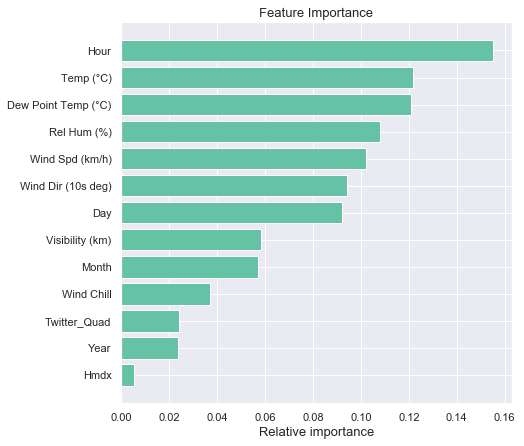

In [4]:
#Tuning Random Forest

# rfc_model = RandomForestClassifier(n_estimators=100)
# param_grid = {'n_estimators': [200, 700, 1000],'max_features': ['auto', 'sqrt', 'log2'],'random_state':[40, 42]}

# CV_rfc = GridSearchCV(estimator=rfc_model, param_grid=param_grid, cv= 5)
# CV_rfc.fit(features,label)
# print (CV_rfc.best_params_)

#Tuned Random Forest...
rfc_tuned = RandomForestClassifier(n_estimators=700,max_features='auto').fit(feat_train,lab_train)
score = rfc_tuned.score(feat_test,lab_test)
print(score)
#print(rfc_tuned.feature_importances_.reshape(-1,1))

importances = rfc_tuned.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(7,7))
sns.set(style='darkgrid', palette = 'Set2')
plt.barh(range(len(indices)),importances[indices],align='center')
plt.title('Feature Importance',fontsize=13)
plt.yticks(range(len(indices)),merged_1.keys()[indices])
plt.xlabel('Relative importance',fontsize=13)
plt.show()


0.5641881638846737


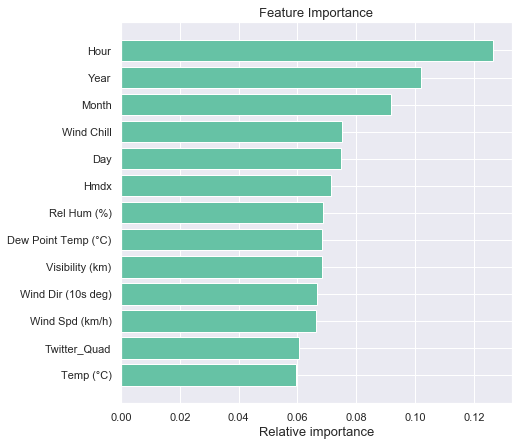

In [5]:
##Tuning XGBoost Steps

# param_test1 = {
#  'max_depth':range(3,10,2),
#  'min_child_weight':range(1,6,2)
# }
# gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
#  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'multi:softmax', nthread=4, scale_pos_weight=1, seed=27), 
#  param_grid = param_test1, n_jobs=4,iid=False, cv=5)
# gsearch1.fit(feat_train,lab_train)
# print (gsearch1.best_params_)

# param_test2 = {
#  'max_depth':[7,8,9,10,11],
#  'min_child_weight':[0,1,2]
# }
# gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
#  min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'multi:softmax', nthread=4, scale_pos_weight=1,seed=27), 
#  param_grid = param_test2,n_jobs=4,iid=False, cv=5)
# gsearch2.fit(feat_train,lab_train)
# print (gsearch2.best_params_)

# param_test3 = {
#  'max_depth':[11,12,13] 
# }
# gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
#  min_child_weight=0, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'multi:softmax', nthread=4, scale_pos_weight=1,seed=27), 
#  param_grid = param_test3,n_jobs=4,iid=False, cv=5)
# gsearch3.fit(feat_train,lab_train)
# print (gsearch3.best_params_)

# param_test4 = {
#  'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100] 
# }
# gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=11,
#  min_child_weight=0, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'multi:softmax', nthread=4, scale_pos_weight=1,seed=27), 
#  param_grid = param_test4,n_jobs=4,iid=False, cv=5)
# gsearch4.fit(feat_train,lab_train)
# print (gsearch4.best_params_)

# param_test5 = {
#     'reg_alpha':[0.001, 0.005, 0.01, 0.05] 
# }
# gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=11,
#  min_child_weight=0, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'multi:softmax', nthread=4, scale_pos_weight=1,seed=27), 
#  param_grid = param_test5,n_jobs=4,iid=False, cv=5)
# gsearch5.fit(feat_train,lab_train)
# print (gsearch5.best_params_)

#Tuned XGBoost Model....
xgb2 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=11,
 min_child_weight=0,
 gamma=0,
 reg_alpha=0.01,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',
 nthread=4,
 scale_pos_weight=1,
 seed=27).fit(feat_train,lab_train)
print (xgb2.score(feat_test,lab_test))

ind = np.argsort(xgb2.feature_importances_)
features.keys()[ind]


importances = xgb2.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(7,7))
sns.set(style='darkgrid', palette = 'Set2')
plt.barh(range(len(indices)),importances[indices],align='center')
plt.title('Feature Importance',fontsize=13)
plt.yticks(range(len(indices)),merged_1.keys()[indices])
plt.xlabel('Relative importance',fontsize=13)
plt.show()

In [6]:
# Tuning Logistic Regression and preparing data for ensemble
data = pd.read_csv('final.csv')
newdata = data[['Temp (°C)','Dew Point Temp (°C)','Rel Hum (%)','Wind Dir (10s deg)','Wind Spd (km/h)', 'Visibility (km)','Stn Press (kPa)','Wind Chill','Year','Month', 'Day', 'Hour' ,'QUADRANT','Quad']]

df = newdata[['Temp (°C)','Dew Point Temp (°C)','Rel Hum (%)','Wind Dir (10s deg)','Wind Spd (km/h)', 'Visibility (km)','Stn Press (kPa)','Wind Chill','Year','Month', 'Day', 'Hour']]

df.fillna(df.mean(),inplace=True)
df['QUADRANT'] = newdata['QUADRANT']
df['Quad'] = newdata['Quad']
df.fillna('0',inplace=True)

labelencoder = LabelEncoder()
df['label_encoding_accidents'] = labelencoder.fit_transform(df[['QUADRANT']])
labelencoder = LabelEncoder()
df['label_encoding_twitter'] = labelencoder.fit_transform(df[['Quad']])

df = df.drop(['QUADRANT','Quad'],axis=1)

y= df.label_encoding_accidents
X = df.drop('label_encoding_accidents',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Tuning Logistic Regression

# logreglist = list()
# C_range = [0.001,0.01,0.1,10,100]
# for x in C_range:
#     logreg = LogisticRegression(C=x,solver='lbfgs', multi_class='multinomial')
#     logreg.fit(X_train_scaled,y_train)
#     logreglist.append(logreg.score(X_test_scaled,y_test))
    
#print(logreglist)

logreg = LogisticRegression(C=0.001,solver='lbfgs', multi_class='multinomial')
logreg.fit(X_train_scaled,y_train)
print("logistic reg with scaling test score: " + str(logreg.score(X_test_scaled,y_test)))
print("logistic reg with scaling train score: " + str(logreg.score(X_train_scaled,y_train)))

logistic reg with scaling test score: 0.47116843702579664
logistic reg with scaling train score: 0.4694218220446153


In [7]:
#Ensemble model

logreg_mod = LogisticRegression(C=0.001,solver='lbfgs', multi_class='multinomial')

xgb_mod = XGBClassifier(learning_rate =0.01,n_estimators=1000,max_depth=11,min_child_weight=0,gamma=0,reg_alpha=0.01,subsample=0.8,colsample_bytree=0.8,objective= 'multi:softmax',nthread=4,scale_pos_weight=1,seed=27)

rfc_mod = RandomForestClassifier(n_estimators=700,max_features='auto',random_state=40)

soft_vote = VotingClassifier(estimators=[('rfc',rfc_mod),('xgb',xgb_mod),('log',logreg_mod)],voting='soft').fit(X_train_scaled,y_train)
score_ens = soft_vote.score(X_test_scaled,y_test)

hard_vote = VotingClassifier(estimators=[('rfc',rfc_mod),('xgb',xgb_mod),('log',logreg_mod)],voting='hard').fit(X_train_scaled,y_train)
score_ens_2 = hard_vote.score(X_test_scaled,y_test)
print ("Ensemble Score on Soft Vote : {:.2f}".format(score_ens))
print ("Ensemble Score on Hard Vote : {:.2f}".format(score_ens_2))

Ensemble Score on Soft Vote : 0.58
Ensemble Score on Hard Vote : 0.56


In [8]:
# Predict Probabilities 

probability = pd.DataFrame(soft_vote.predict_proba(X_test_scaled))

probability.columns = ['No accident','NE' ,'NW' ,'SE' ,'SW']
probability
predictions = pd.DataFrame(soft_vote.predict(X_test_scaled))
predictions
predictions['Confidence'] = probability[['No accident','NE','NW', 'SE', 'SW']].max(axis=1)
predictions.columns = ['Accident Quadrant', 'Confidence']
predictions
act_lab = pd.DataFrame(y_test).reset_index(drop=True)
predictions['Actual Quadrant'] = act_lab
predictions

,Accident Quadrant,Confidence,Actual Quadrant
0,0,0.813268,0
1,0,0.393624,4
2,0,0.362258,1
3,0,0.500200,0
4,3,0.406950,0
5,0,0.509670,2
6,1,0.400387,3
7,0,0.498627,0
8,4,0.295269,2
9,0,0.466219,2


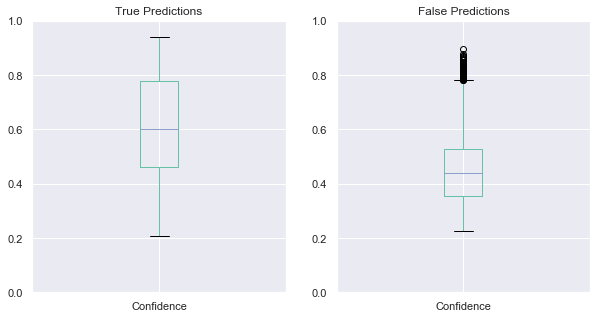

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pred_true = predictions[predictions['Accident Quadrant']==predictions['Actual Quadrant']]
pred_false = predictions[predictions['Accident Quadrant']!=predictions['Actual Quadrant']]
fig = plt.figure(figsize=(10,5))
sns.set(style='darkgrid',palette='Set2')
fig.add_subplot(121)
pred_true.boxplot(column=['Confidence'])
plt.title('True Predictions')
plt.ylim(0,1)
fig.add_subplot(122)
pred_false.boxplot(column=['Confidence'])
plt.title('False Predictions')
plt.ylim(0,1)
plt.show()

In [10]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(predictions['Actual Quadrant'],predictions['Accident Quadrant'])
cm

array([[2985,   23,   24,   67,   19],
       [ 273,  160,   99,  240,   87],
       [ 254,   97,  168,  154,   67],
       [ 365,  163,  125,  356,  113],
       [ 269,   93,   70,  196,  123]])